# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *A non-local algorithm for image denoising* autorstwa Antoni Buades, Bartomeu Coll, i Jean Michel Morel na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation}

gdzie:
- \begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in  V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\end{equation},
- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując. Jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

from itertools import product
from scipy.stats import norm

if not os.path.exists("MR_data.mat") :
    !wsl wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

In [2]:
mat = loadmat('MR_data.mat')

In [3]:
noisefree = mat['I_noisefree']
noisy1 = mat['I_noisy1']
noisy2 = mat['I_noisy2']
noisy3 = mat['I_noisy3']
noisy4 = mat['I_noisy4']

In [4]:
def plot_img(img, cmap='gray', title=''):
    plt.figure(figsize=(img.shape[0]/30,img.shape[1]/30))
    plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [5]:
def plot_convolution(img, dst,
                     show_orig=True, show_dst=True, show_diff=True):
    cols = show_orig + show_dst + show_diff

    fig, axs = plt.subplots(ncols=cols, figsize=(cols * 5, 5))
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    if show_orig: 
        index = 0
        axs[index].imshow(img, cmap='gray', vmin=0, vmax=255)
        axs[index].set_title('Original image')

    if show_dst:
        index = int(show_orig)
        axs[index].imshow(dst, cmap='gray', vmin=0, vmax=255)
        axs[index].set_title('Processed image')

    if show_diff:
        index = int(show_orig + show_dst)

        df = dst.astype(np.int32) - img.astype(np.int32)
        max_val = np.max(np.abs(df))
        df[0, 0] = max_val
        df[-1, -1] = -max_val

        axs[index].imshow(df, cmap='coolwarm')
        axs[index].set_title('Difference')

    plt.show()

In [6]:
def gaussian_window(window_size=5, sigma=1.5):
    def distance(x, y, i, j):
        return np.linalg.norm([x - i, y - j])
    
    def gauss(v):
        return norm.pdf(v, loc=0, scale=sigma)
    
    window = np.zeros((window_size, window_size))
    x, y = window_size // 2, window_size // 2
    
    for i, j in product(range(window_size), range(window_size)):
        dist = distance(x, y, i, j)
        window[i, j] = gauss(dist)
        
    Wn = np.sum(window)
    
    return window / Wn

In [7]:
def non_local_means(img, window_size=11, context_size=3, alpha=1.0, sigma=1.0):
    assert window_size % 2 == 1, 'window size must be an odd number'
    assert context_size % 2 == 1, 'context size must be an odd number'

    gaussian = gaussian_window(context_size)
    
    window_size_orig = window_size
    window_size = window_size // 2
    context_size = context_size // 2
        
    def context_distance(Np, Nx):
        return np.linalg.norm(gaussian * Np - gaussian * Nx)
    
    def w(Np, Nx):
        return np.exp(-context_distance(Np, Nx) / (alpha * sigma * sigma))
        
    def local_weighing(image_window):
        lwindow = np.zeros((window_size_orig, window_size_orig))
        
        i, j = image_window.shape[0] // 2, image_window.shape[1] // 2
        Nx = image_window[i-context_size:i+context_size+1, 
                          j-context_size:j+context_size+1]
        
        for x in range(context_size, image_window.shape[0] - context_size):
            for y in range(context_size, image_window.shape[1] - context_size):
                lwindow[x - context_size, y - context_size] = w(
                    image_window[x-context_size:x+context_size+1, 
                                 y-context_size:y+context_size+1],
                    Nx
                )
        
        lwindow = lwindow / np.sum(lwindow)
        
        return np.sum(lwindow * image_window[context_size:-context_size,
                                             context_size:-context_size])
    
    convoluted = np.copy(img)
    margin = context_size + window_size
    for i in range(margin, img.shape[0]-margin):
        for j in range(margin, img.shape[1]-margin):
            image_window = img[i-margin:i+margin+1, j-margin:j+margin+1]
            convoluted[i, j] = local_weighing(image_window)
        
    return convoluted.astype(np.uint8)

In [8]:
def convolution(img, window=gaussian_window()):
    window_size = window.shape[0] // 2
    
    assert window.shape[0] % 2 == 1, 'window size must be an odd number'
    
    convoluted = np.copy(img)
    for i in range(window_size, img.shape[0]-window_size):
        for j in range(window_size, img.shape[1]-window_size):
            convoluted[i, j] = np.sum(
                img[i-window_size:i+window_size+1, j-window_size:j+window_size+1] * window
            )
        
    return convoluted.astype(np.uint8)

In [9]:
def bilateral_convolution(img, window=gaussian_window(), sigma_r=15.0):
    window_size = window.shape[0] // 2
    
    assert window.shape[0] % 2 == 1, 'window size must be an odd number'

    def gamma(v):
        v = np.int64(v)
        return np.exp(- (v * v) / (2 * sigma_r * sigma_r))
    
    def local_weighing(image_window, v):
        lwindow = np.copy(window)
        for x in range(window_size):
            for y in range(window_size):
                lwindow[x, y] = lwindow[x, y] * gamma(v - image_window[x, y])
        return np.sum(lwindow * image_window) / np.sum(lwindow)
    
    convoluted = np.copy(img)
    for i in range(window_size, img.shape[0]-window_size):
        for j in range(window_size, img.shape[1]-window_size):
            image_window = img[i-window_size:i+window_size+1, j-window_size:j+window_size+1]
            convoluted[i, j] = local_weighing(image_window, img[i, j])
        
    return convoluted.astype(np.uint8)

### _noisefree_

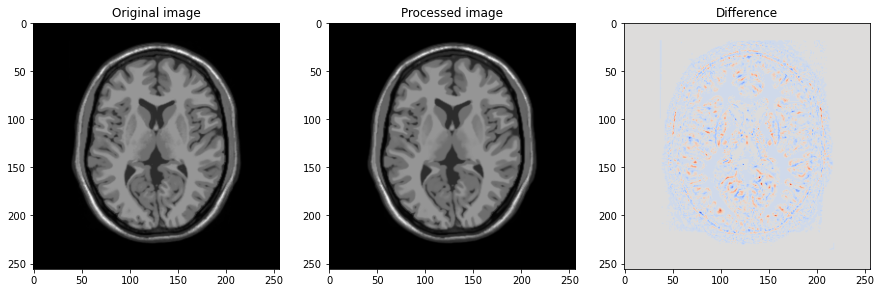

Wall time: 1min 24s


In [10]:
%%time
dst = non_local_means(noisefree)
plot_convolution(noisefree, dst)

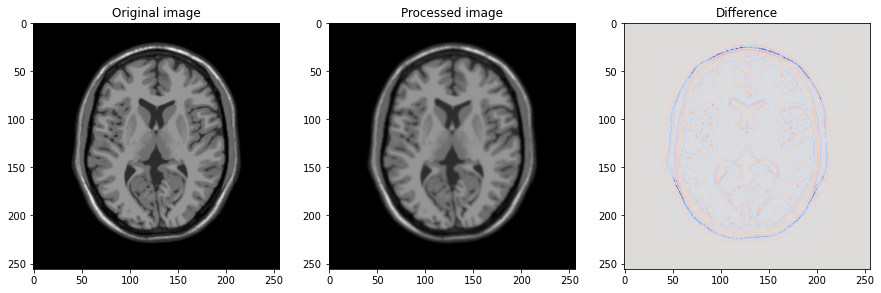

Wall time: 762 ms


In [11]:
%%time
dst2 = convolution(noisefree, gaussian_window(sigma=0.8))
plot_convolution(noisefree, dst2)

C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


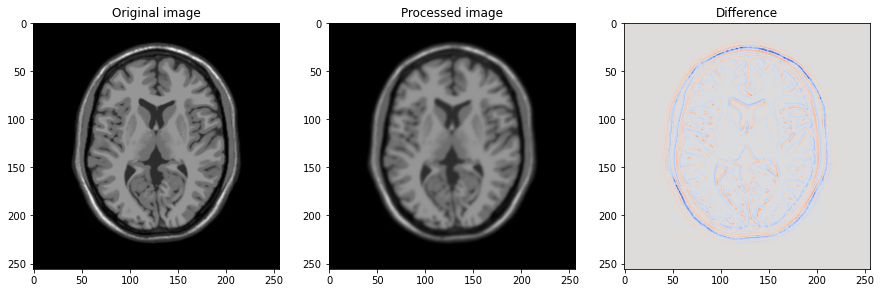

Wall time: 2.97 s


In [12]:
%%time
dst3 = bilateral_convolution(noisefree)
plot_convolution(noisefree, dst3)

### _noisy1_

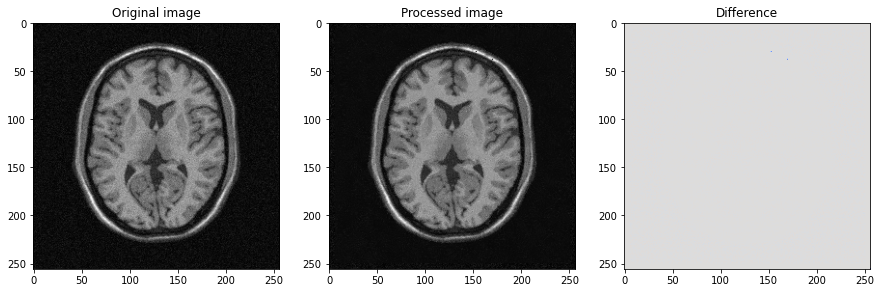

Wall time: 1min 26s


In [13]:
%%time
dst = non_local_means(noisy1)
plot_convolution(noisy1, dst)

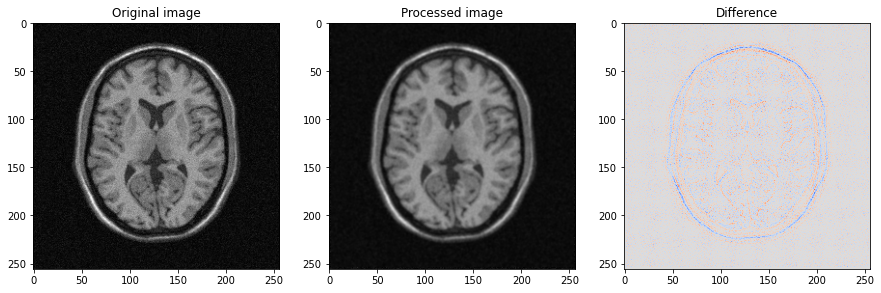

Wall time: 792 ms


In [14]:
%%time
dst2 = convolution(noisy1, gaussian_window(sigma=0.8))
plot_convolution(noisy1, dst2)

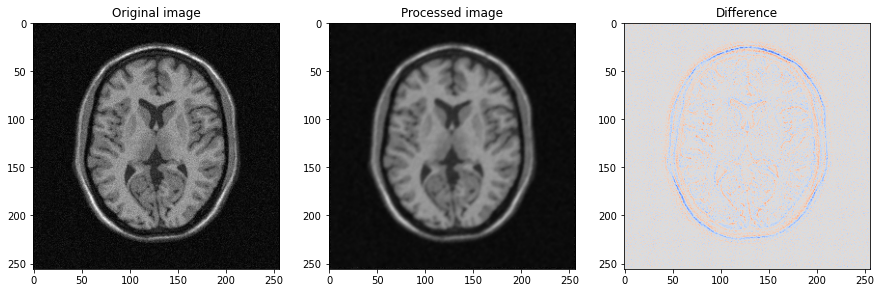

Wall time: 2.66 s


In [15]:
%%time
dst3 = bilateral_convolution(noisy1)
plot_convolution(noisy1, dst3)

### _noisy2_

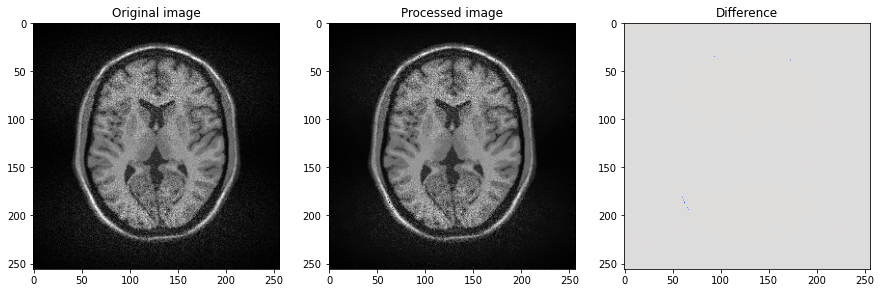

Wall time: 1min 27s


In [16]:
%%time
dst = non_local_means(noisy2)
plot_convolution(noisy2, dst)

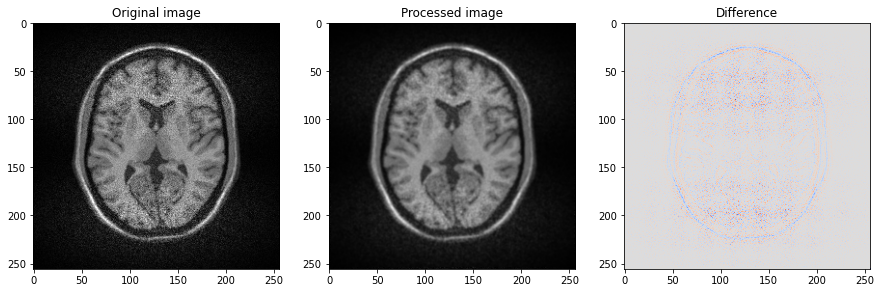

Wall time: 658 ms


In [17]:
%%time
dst2 = convolution(noisy2, gaussian_window(sigma=0.8))
plot_convolution(noisy2, dst2)

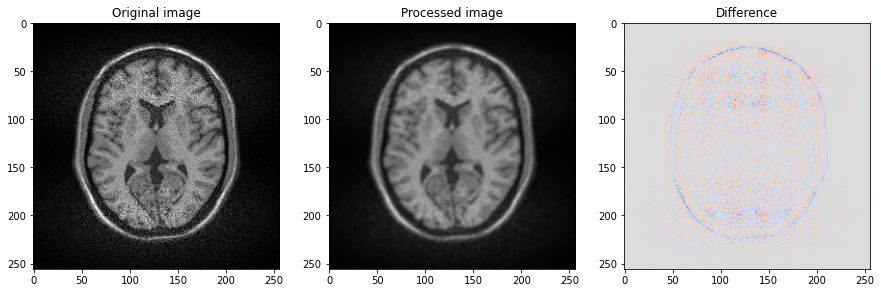

Wall time: 2.96 s


In [18]:
%%time
dst3 = bilateral_convolution(noisy2)
plot_convolution(noisy2, dst3)

### _noisy3_

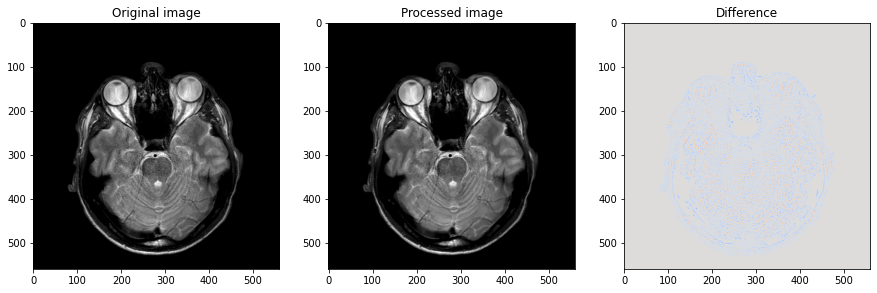

Wall time: 7min 13s


In [19]:
%%time
dst = non_local_means(noisy3)
plot_convolution(noisy3, dst)

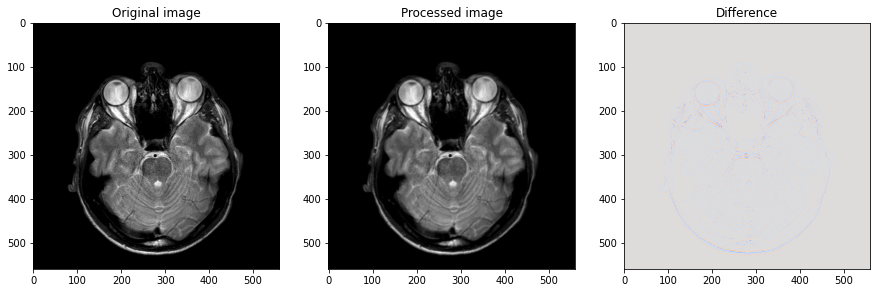

Wall time: 2.63 s


In [20]:
%%time
dst2 = convolution(noisy3, gaussian_window(sigma=0.8))
plot_convolution(noisy3, dst2)

C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


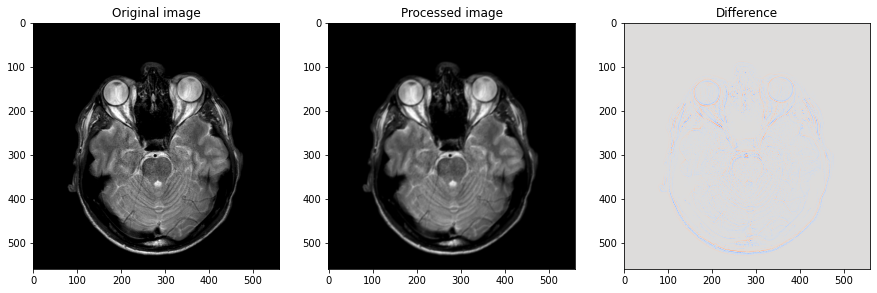

Wall time: 13.2 s


In [21]:
%%time
dst3 = bilateral_convolution(noisy3)
plot_convolution(noisy3, dst3)

### _noisy4_

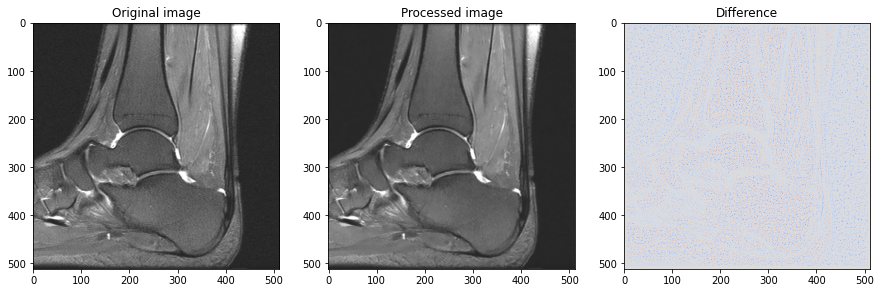

Wall time: 6min 10s


In [22]:
%%time
dst = non_local_means(noisy4)
plot_convolution(noisy4, dst)

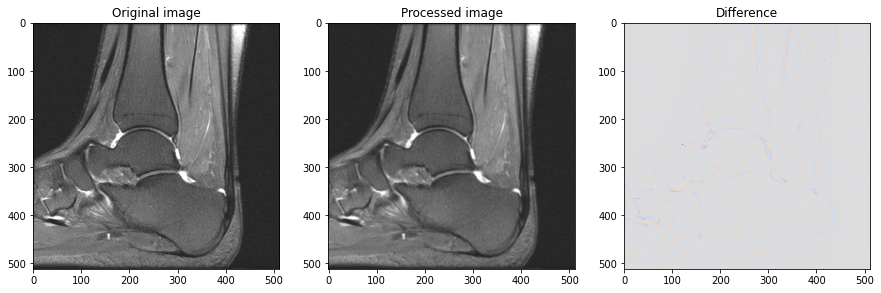

Wall time: 2.31 s


In [23]:
%%time
dst2 = convolution(noisy4, gaussian_window(sigma=0.8))
plot_convolution(noisy4, dst2)

C:\Users\Hyperbook\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


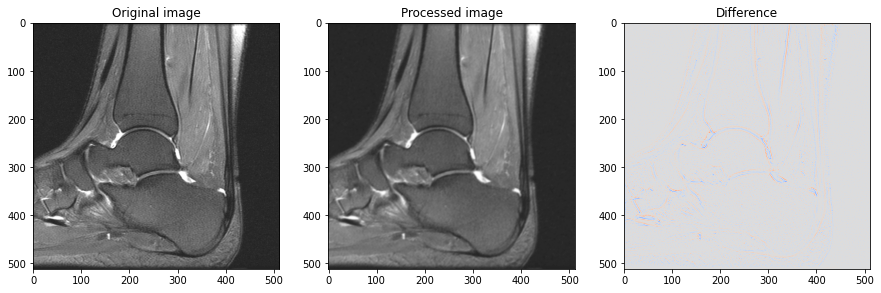

Wall time: 11.5 s


In [24]:
%%time
dst3 = bilateral_convolution(noisy4)
plot_convolution(noisy4, dst3)

## Czas działania

Klasyczcna konwolucja:

* 1.77 s

Filtr bilateralny:

* 6.59 s

Non local means:

* 3 min 32 s

Widzimy, że czas dla obliczenia NLM jest dużo większy od innych algorytmów.

## Porównanie filtrów

Wyniki są dużo lepsze dla NLM, widać że zachowuje się ostrość zdjęcia lepiej. Daje to możliwość uzyskać lepszą jakość, natomiast ten algorytm raczej nie jest przydatny dla przetwarzania obrazów w czasie rzeczywistych, ponieważ czas obliczeń jest obrzymi.